In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define relative entropy function to calculate the Kullback-Leibler divergence
# This function helps measure how one probability distribution diverges from a second, expected distribution
def relative_entropy(P, Q):
    # Logarithm in KL divergence; added a small value inside the log to avoid log(0) scenario
    return np.sum(P * np.log(P / Q + 1e-10), where=(P > 0))

# Define a function to compute a tilted distribution based on two distributions and a parameter lambda
def tilted_distribution(P1, P2, lambda_):
    # Calculate the weighted power of distributions P1 and P2
    numerator = np.power(P1, 1-lambda_) * np.power(P2, lambda_)
    # Normalize to make it a probability distribution
    denominator = np.sum(numerator)
    return numerator / denominator

# Define the constraint function that the optimization has to satisfy
def constraint(lambda_, P1, P2, gamma):
    # Generate the tilted distribution for the current lambda
    Q_lambda = tilted_distribution(P1, P2, lambda_)
    # Calculate the divergences to P1 and P2
    D1 = relative_entropy(Q_lambda, P1)
    D2 = relative_entropy(Q_lambda, P2)
    # Constraint ensures that divergence to P1 is at least gamma more than divergence to P2
    return D1 - D2 - gamma  # Needs to be >= 0

# Define the objective function to minimize (KL divergence to P1)
def objective(lambda_, P1, P2):
    # Calculate tilted distribution for current lambda
    Q_lambda = tilted_distribution(P1, P2, lambda_)
    # Return divergence to P1
    return relative_entropy(Q_lambda, P1)

# Callback function to store results for plotting
def callback(lambda_, P1, P2, gamma):
    Q_lambda = tilted_distribution(P1, P2, lambda_)
    divergence = relative_entropy(Q_lambda, P1)
    D1 = relative_entropy(Q_lambda, P1)
    D2 = relative_entropy(Q_lambda, P2)
    constraint_value = D1 - D2 - gamma
    lambda_history.append(lambda_[0])
    divergence_history.append(divergence)
    constraint_history.append(constraint_value)



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1004581674661636
            Iterations: 3
            Function evaluations: 7
            Gradient evaluations: 3


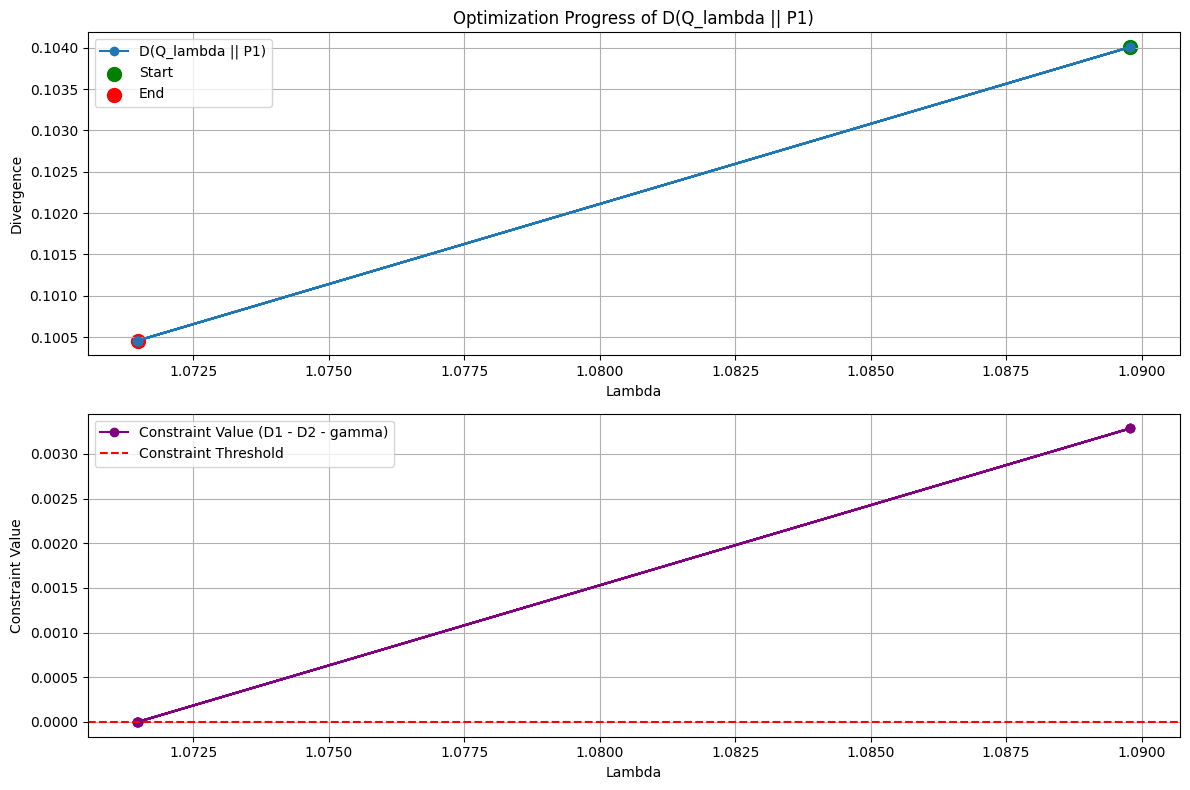

Optimization successful.
Optimized lambda: 1.0714694562122697
Optimal Q: [0.51513435 0.48486565]
Minimum D(Q_lambda || P1): 0.1004581674661636


In [13]:
# Setup example distributions and gamma
P1 = np.array([0.3, 0.7])
P2 = np.array([0.5, 0.5])
gamma = 0.1

# Prepare the constraint for the optimization problem
cons = {'type': 'ineq', 'fun': constraint, 'args': (P1, P2, gamma)}

# Setup initial guess and execute the minimization
initial_lambda = 0.5
result = minimize(objective, x0=[initial_lambda], args=(P1, P2), method='SLSQP', constraints=cons, callback=lambda x: callback(x, P1, P2, gamma), options={'disp': True})

# Plotting the results of the optimization
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(lambda_history, divergence_history, '-o', label='D(Q_lambda || P1)')
plt.scatter([lambda_history[0]], [divergence_history[0]], color='green', s=100, label='Start')
plt.scatter([lambda_history[-1]], [divergence_history[-1]], color='red', s=100, label='End')
plt.title('Optimization Progress of D(Q_lambda || P1)')
plt.xlabel('Lambda')
plt.ylabel('Divergence')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(lambda_history, constraint_history, '-o', color='purple', label='Constraint Value (D1 - D2 - gamma)')
plt.axhline(y=0, color='r', linestyle='--', label='Constraint Threshold')
plt.xlabel('Lambda')
plt.ylabel('Constraint Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print the results if the optimization was successful
if result.success:
    lambda_opt = result.x[0]
    Q_opt = tilted_distribution(P1, P2, lambda_opt)
    E1 = relative_entropy(Q_opt, P1)
    print("Optimization successful.")
    print("Optimized lambda:", lambda_opt)
    print("Optimal Q:", Q_opt)
    print("Minimum D(Q_lambda || P1):", E1)
else:
    print("Optimization failed.")
